# Import the dependencies

In [1]:
import re
import random
import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import Counter

import tensorflow as tf
import tensorflow_addons as tfa
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Conv1D, GlobalAveragePooling1D
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
from transformers import BertConfig
from transformers import RobertaTokenizerFast

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

from matplotlib import pyplot as plt
from matplotlib import rcParams

import sys
import time

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

sys.path.append("../../../")
from calculus_path_mod.terms.pseudonym import *
from calculus_path_mod.reduction_strategy import *
from calculus_path_mod.terms.arithm_complex_ops import *

C:\Users\voldo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\voldo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\voldo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Py

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
sequence_len = 512
batch_size = 64

config = BertConfig(
    vocab_size=9,
    hidden_size=84,
    num_hidden_layers=2,
    num_attention_heads=6,
    intermediate_size=64,
    max_position_embeddings=sequence_len,
    num_labels=2
)

epochs = 30

# Load & Prepare the data

In [4]:
all_data = pd.read_csv("../../article_models_reduct_steps_by_simple_str/data_steps/steps_simple_term_str.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)
all_data = all_data.drop_duplicates(["simple_terms"])

# drop unreducable by LO or RI
print(f"number samples: {len(all_data)}")
all_data = all_data[[x_ != 1000 for x_ in all_data["RI_steps_num"]]].reset_index(drop=True)
all_data = all_data[[x_ != 1000 for x_ in all_data["LO_steps_num"]]].reset_index(drop=True)
print(f"number samples only reducable: {len(all_data)}\n")

print(f"max RI steps count: {max(all_data['RI_steps_num'])}")
print(f"max LO steps count: {max(all_data['LO_steps_num'])}")

x_test = all_data["simple_terms"].tolist()
y_ri_test = all_data["RI_steps_num"].tolist()
y_lo_test = all_data["LO_steps_num"].tolist()

print(f"Count TESTING samples: {len(y_ri_test)}")

Count all terms: 4251

Count original terms: 4251

number samples: 4251
number samples only reducable: 4220

max RI steps count: 386
max LO steps count: 219
Count TESTING samples: 4220


In [5]:
all_data = pd.read_csv("../../article_models_reduct_steps_by_simple_str/data_steps/steps_simple_term_str_extended.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)
all_data = all_data.drop_duplicates(["simple_terms"])

# drop unreducable by LO or RI
print(f"number samples: {len(all_data)}")
all_data = all_data[[x_ != 1000 for x_ in all_data["RI_steps_num"]]].reset_index(drop=True)
all_data = all_data[[x_ != 1000 for x_ in all_data["LO_steps_num"]]].reset_index(drop=True)
print(f"number samples only reducable: {len(all_data)}\n")

print(f"max RI steps count: {max(all_data['RI_steps_num'])}")
print(f"max LO steps count: {max(all_data['LO_steps_num'])}")

x_train = all_data["simple_terms"].tolist()
y_ri_train = all_data["RI_steps_num"].tolist()
y_lo_train = all_data["LO_steps_num"].tolist()

print(f"Count TRAINING samples: {len(y_ri_train)}")

Count all terms: 44568

Count original terms: 44568

number samples: 44568
number samples only reducable: 42469

max RI steps count: 400
max LO steps count: 308
Count TRAINING samples: 42469


In [6]:
tokenizer = RobertaTokenizerFast.from_pretrained("../../transformers_to_lo_steps_prediciton/fine_models", max_len=sequence_len)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
x_train = [x_.replace("@x.", "y").replace(" ", "") for x_ in x_train]
x_test = [x_.replace("@x.", "y").replace(" ", "") for x_ in x_test]

In [8]:
def get_sample_weight(arr_1, arr_2):
    arr_1, arr_2 = np.array(arr_1), np.array(arr_2)
    abs_diff = np.abs(arr_1 - arr_2)
    abs_diff += 2
    return np.log(abs_diff) - 0.6


def get_diff_steps(arr_1, arr_2):
    arr_1, arr_2 = np.array(arr_1), np.array(arr_2)
    abs_diff = np.abs(arr_1 - arr_2)
    abs_diff = np.log1p(abs_diff)
    sign_diff = np.sign(arr_1 - arr_2)
    return abs_diff * sign_diff


train_df = pd.DataFrame({
    "term_str": x_train, "diff_steps": get_diff_steps(y_lo_train, y_ri_train),
    "lo_steps": y_lo_train, "ri_steps": y_ri_train,

    "sample_weights": get_sample_weight(y_ri_train, y_lo_train),
})
test_df = pd.DataFrame({
    "term_str": x_test, "diff_steps": get_diff_steps(y_lo_test, y_ri_test),
    "lo_steps": y_lo_test, "ri_steps": y_ri_test,
    "sample_weights": get_sample_weight(y_ri_test, y_lo_test),
})

In [9]:
train_df.head(10)

,term_str,diff_steps,lo_steps,ri_steps,sample_weights
0,(y(y((x(y((x(y((x((x((xx)(y(((xx)(((yx)(x((yx)...,0.000000,3,3,0.093147
1,((((((((y(y(yx)))(y(yx)))(((yx)(y(y((x(y(y(y(y...,-4.852030,60,187,4.259812
2,(y(y(x(((((y(yx))(yx))((y(y(yx)))(y(y(xx)))))(...,-1.386294,5,8,1.009438
3,(y(((x((xx)(x(x(xx)))))((x((x(yx))(xx)))((y(x(...,1.386294,7,4,1.009438
4,(y((x(y((((x(x(y(y(x((xx)x))))))(x(((y(x((x((y...,0.000000,2,2,0.093147
5,(y(y(((((((x(x(y(yx))))(x(x(y(x(x(y(yx))))))))...,-4.077537,20,78,3.494345
6,((y(y(y((y(y((yx)x)))(x(((yx)(yx))((((y(yx))(y...,-1.791759,3,8,1.345910
7,((y((((y(xx))(y((yx)(y(x(y(yx)))))))(y((y(x((y...,-3.044522,11,31,2.491042
8,(y(((y(yx))(y(y(x((y(x((y(yx))(y(y(y(xx)))))))...,-1.945910,10,16,1.479442
9,(y(y(y(((y((yx)x))(yx))(y(yx)))))),0.000000,3,3,0.093147


In [10]:
test_df.head(10)

,term_str,diff_steps,lo_steps,ri_steps,sample_weights
0,(y(y(x(y((x(x(((x(y((xx)(x(y(yx))))))x)(y(y(xx...,0.000000,0,0,0.093147
1,(((((((y(y(yx)))(y(y(xx))))((y(((y(y(yx)))(y(y...,-2.995732,28,47,2.444522
2,(y(y(y(((x(yx))(yx))((x(y((yx)(y(x((((yx)(((xx...,-0.693147,1,2,0.498612
3,(y((((((((y(y(x(xx))))(y(y(y(y(xx))))))(((y(y(...,-2.890372,58,75,2.344439
4,(y(y(((xx)(y(y(y((x((((yx)(yx))(((yx)(yx))(((y...,0.000000,8,8,0.093147
5,((((yx)(y((y(y((xx)(y((yx)x)))))((yx)(y((yx)(x...,-2.639057,10,23,2.108050
6,(y(x(y(y(y(y(x((y(y((yx)(y(y(xx))))))(y(y(((y(...,-0.693147,4,5,0.498612
7,(((((((((yx)(y(xx)))(yx))(((yx)(y(xx)))(yx)))(...,-2.079442,84,91,1.597225
8,(y(((x(yx))(y((xx)((x((((x(xx))(xx))x)(y(y((xx...,0.000000,1,1,0.093147
9,(y(y(y(y(y(x(y((y(y(xx)))x)))))))),0.000000,1,1,0.093147


In [11]:
def preprocess(example):
    # Tokenize the prompt
    tokenized_texts = tokenizer(example['term_str'].to_list(), truncation=True, padding='max_length', max_length=sequence_len, return_tensors="tf")
    labels = tf.convert_to_tensor(example["diff_steps"])
    sample_weights = tf.convert_to_tensor(example["sample_weights"])
    return tokenized_texts, labels, sample_weights


tokenized_train_data = preprocess(train_df)
tokenized_test_data = preprocess(test_df)

In [12]:
# train_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_train_data[0]), tokenized_train_data[1], tokenized_train_data[2])).batch(batch_size)
train_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_train_data[0]), tokenized_train_data[1])).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_test_data[0]), tokenized_test_data[1])).batch(batch_size)

# Define & Train the Model

In [13]:
# Define the model
from transformers import TFBertModel
from keras.layers import Dense, Input, Flatten, AveragePooling1D, Dropout
from keras.models import Model

bert = TFBertModel(config=config)
bert.build()

input_ids_in = Input(shape=(sequence_len,), name='input_ids', dtype='int32')
input_masks_in = Input(shape=(sequence_len,), name='attention_mask', dtype='int32')

embedding_layer = bert(input_ids_in, attention_mask=input_masks_in)[0]
outputs = AveragePooling1D(pool_size=50)(embedding_layer)
outputs = Flatten()(outputs)
# outputs = Dropout(rate=0.1)(outputs)
outputs = Dense(units=128, activation="relu")(outputs)
outputs = Dense(units=1)(outputs)
model = Model(inputs=[input_ids_in, input_masks_in], outputs=outputs)

In [17]:
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mean_absolute_error', ])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  130832      ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [15]:
model_structure = model.to_json()
with open("./fine_models/model_diff_v1.json", 'w') as json_file:
    json_file.write(model_structure)

In [16]:
# Define the ModelCheckpoint callback
f1_callback = ModelCheckpoint(
    filepath='./fine_models/model_diff_best_MSE_v1.h5',  # Specify the path to save the best model
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model
    mode='max',  # 'min' or 'max' depending on the monitored metric
    verbose=0  # Print a message when saving the model
)

step_callback = ModelCheckpoint('./fine_models/model_diff_v1.h5', save_weights_only=True, save_freq=1)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/id_1", histogram_freq=1)

In [15]:
def draw_training_statistic(history_):
    plt.plot(range(1, epochs + 1), history_.history['loss'], label="MSE")
    plt.plot(range(1, epochs + 1), history_.history['val_loss'], label="val MSE")
    plt.xlabel("epochs")
    plt.title("total loss")
    plt.legend()
    plt.show()

    plt.plot(range(1, epochs + 1), history_.history['mean_absolute_error'], label="MAE")
    plt.plot(range(1, epochs + 1), history_.history['val_mean_absolute_error'], label="val MAE")
    plt.xlabel("epochs")
    plt.title("total MAE")
    plt.legend()
    plt.show()

    plt.plot(range(1, epochs + 1), history_.history['root_mean_squared_error'], label="RMSE")
    plt.plot(range(1, epochs + 1), history_.history['val_root_mean_squared_error'], label="val RMSE")
    plt.xlabel("epochs")
    plt.title("total RMSE")
    plt.legend()
    plt.show()

Epoch 1/30
664/664 [==============================] - 168s 247ms/step - loss: 2.7036 - root_mean_squared_error: 1.6443 - mean_absolute_error: 1.1458 - val_loss: 2.1882 - val_root_mean_squared_error: 1.4793 - val_mean_absolute_error: 1.0628
Epoch 2/30
664/664 [==============================] - 160s 242ms/step - loss: 2.4328 - root_mean_squared_error: 1.5597 - mean_absolute_error: 1.0695 - val_loss: 2.1516 - val_root_mean_squared_error: 1.4668 - val_mean_absolute_error: 1.0352
Epoch 3/30
664/664 [==============================] - 162s 244ms/step - loss: 2.3438 - root_mean_squared_error: 1.5310 - mean_absolute_error: 1.0408 - val_loss: 2.1292 - val_root_mean_squared_error: 1.4592 - val_mean_absolute_error: 0.9901
Epoch 4/30
664/664 [==============================] - 161s 242ms/step - loss: 2.2844 - root_mean_squared_error: 1.5114 - mean_absolute_error: 1.0232 - val_loss: 2.0987 - val_root_mean_squared_error: 1.4487 - val_mean_absolute_error: 0.9562
Epoch 5/30
664/664 [====================

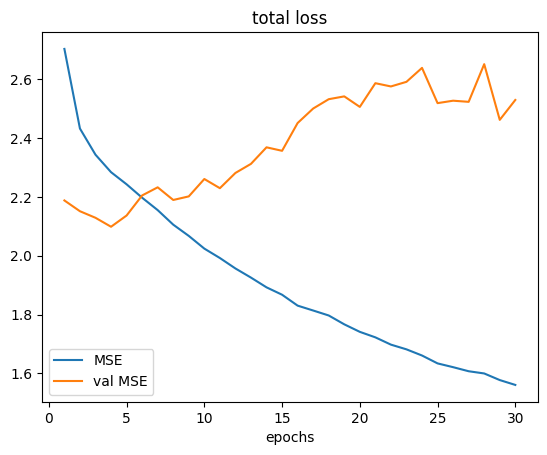

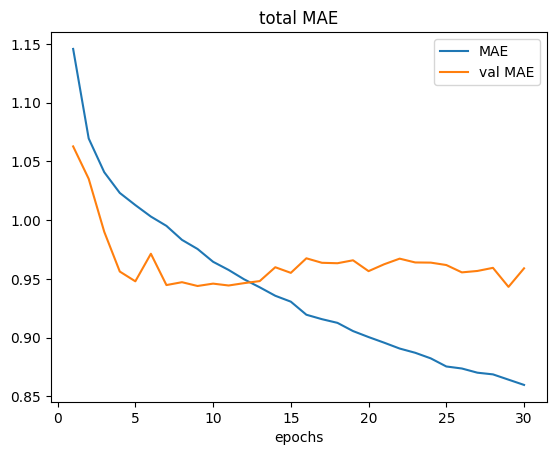

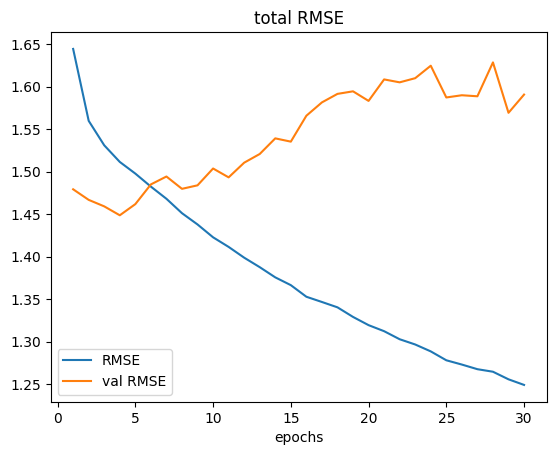

In [19]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, verbose=1,
                    callbacks=[f1_callback, step_callback, tensorboard_callback])

draw_training_statistic(history)

In [ ]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, verbose=1,
                    callbacks=[f1_callback, step_callback, tensorboard_callback])

draw_training_statistic(history)

Epoch 1/30
664/664 [==============================] - 156s 235ms/step - loss: 1.5439 - root_mean_squared_error: 1.2425 - mean_absolute_error: 0.8559 - val_loss: 2.5933 - val_root_mean_squared_error: 1.6104 - val_mean_absolute_error: 0.9578
Epoch 2/30
664/664 [==============================] - 156s 235ms/step - loss: 1.5214 - root_mean_squared_error: 1.2334 - mean_absolute_error: 0.8505 - val_loss: 2.5273 - val_root_mean_squared_error: 1.5897 - val_mean_absolute_error: 0.9495
Epoch 3/30
664/664 [==============================] - 156s 235ms/step - loss: 1.5098 - root_mean_squared_error: 1.2287 - mean_absolute_error: 0.8484 - val_loss: 2.5879 - val_root_mean_squared_error: 1.6087 - val_mean_absolute_error: 0.9619
Epoch 4/30
664/664 [==============================] - 156s 236ms/step - loss: 1.4985 - root_mean_squared_error: 1.2241 - mean_absolute_error: 0.8450 - val_loss: 2.6024 - val_root_mean_squared_error: 1.6132 - val_mean_absolute_error: 0.9655
Epoch 5/30
664/664 [====================

Epoch 1/30
664/664 [==============================] - 187s 275ms/step - loss: 1.2411 - root_mean_squared_error: 1.1141 - mean_absolute_error: 0.7818 - val_loss: 2.7488 - val_root_mean_squared_error: 1.6580 - val_mean_absolute_error: 0.9932
Epoch 2/30
664/664 [==============================] - 183s 275ms/step - loss: 1.2320 - root_mean_squared_error: 1.1099 - mean_absolute_error: 0.7786 - val_loss: 2.7287 - val_root_mean_squared_error: 1.6519 - val_mean_absolute_error: 0.9811
Epoch 3/30
664/664 [==============================] - 172s 259ms/step - loss: 1.2346 - root_mean_squared_error: 1.1111 - mean_absolute_error: 0.7786 - val_loss: 2.7534 - val_root_mean_squared_error: 1.6593 - val_mean_absolute_error: 0.9917
Epoch 4/30
664/664 [==============================] - 159s 239ms/step - loss: 1.2029 - root_mean_squared_error: 1.0968 - mean_absolute_error: 0.7717 - val_loss: 2.8029 - val_root_mean_squared_error: 1.6742 - val_mean_absolute_error: 1.0024
Epoch 5/30
664/664 [====================

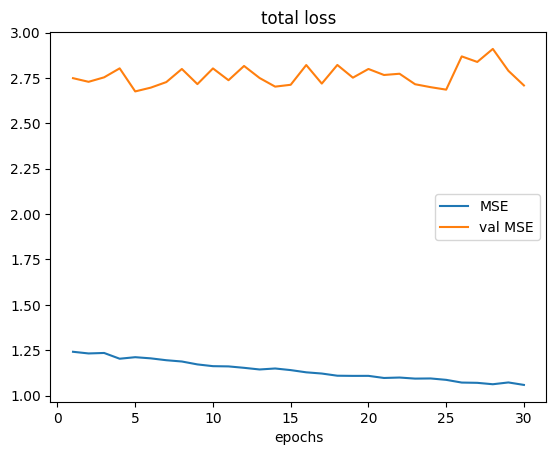

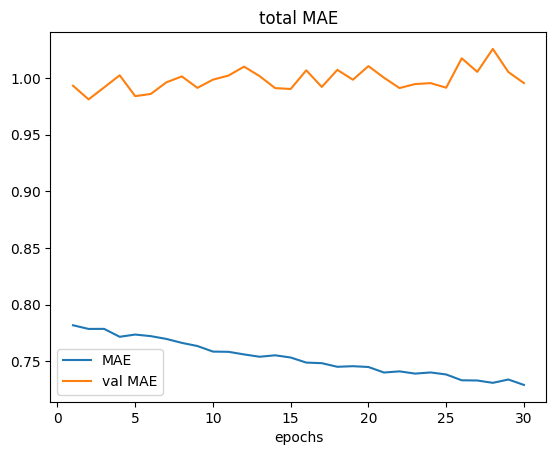

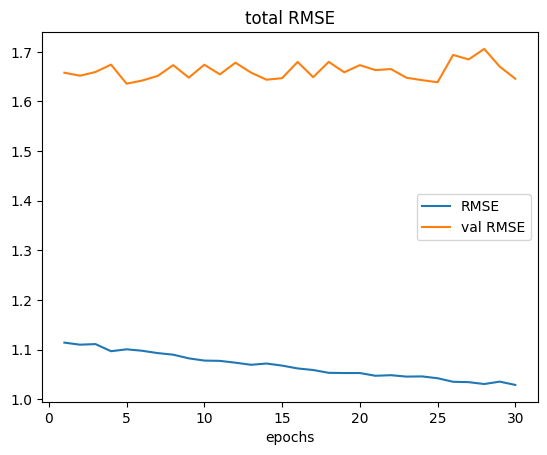

In [18]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, verbose=1,
                    callbacks=[f1_callback, step_callback, tensorboard_callback])

draw_training_statistic(history)

# TRAINED MODEL (after 90 epochs)

In [19]:
def draw_pred_scatter(y_pred, y_real, title_info="TEST"):
    plt.scatter(y_real, y_pred, s=3)
    min_val = min(min(y_pred), min(y_real))
    max_val = max(max(y_pred), min(y_real))
    plt.plot([min_val, min_val], [max_val, max_val], color='gray', linestyle='--')

    plt.xlabel("Real reduction step diff")
    plt.ylabel("Predicted step diff")
    plt.title(f"{title_info} Pred vs Real Reduction step diff")
    plt.show()

In [20]:
def draw_pred_lines_scatter(y_pred, y_real, title_info="TEST"):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    plt.plot(range(len(drawing_df["Real"])), drawing_df["Real"], label="Real", c=colors[1])
    plt.scatter(range(len(drawing_df["Pred"])), drawing_df["Pred"], label="Pred", s=3, c=colors[0])

    plt.xlabel("No")
    plt.ylabel("Step diff")
    plt.title(f"{title_info} Pred vs Real Step Diff")
    plt.legend()
    plt.show()

In [41]:
def conv_to_steps(arr_steps):
    arr_steps = np.array(arr_steps)
    abs_arr = np.abs(arr_steps)
    sign_arr = np.sign(arr_steps)

    abs_arr = np.exp(abs_arr) - 1
    return abs_arr * sign_arr

In [40]:
y_test_pred = model.predict(test_dataset)
y_train_pred = model.predict(train_dataset)

y_test_nums = test_df["diff_steps"]
y_train_nums = train_df["diff_steps"]

664/664 [==============================] - 33s 50ms/step


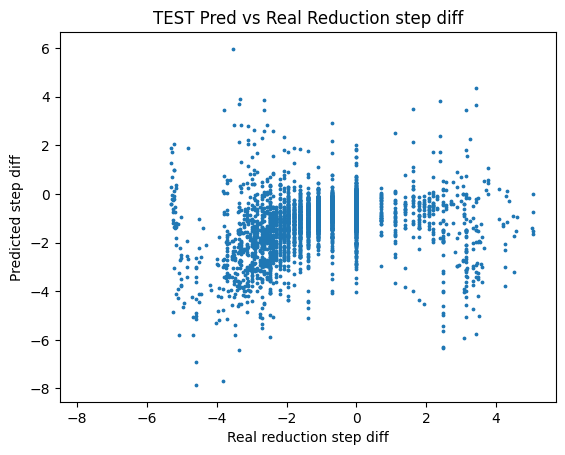

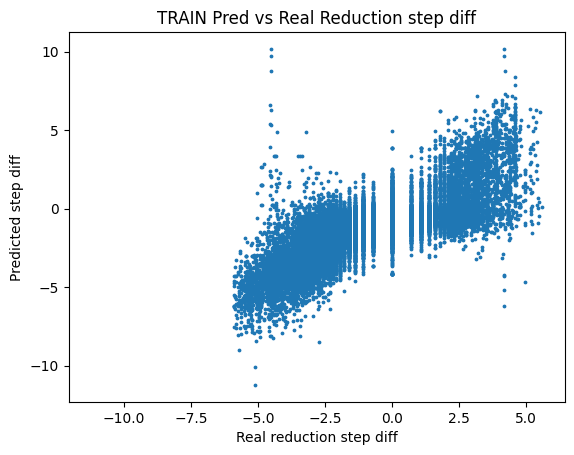

In [36]:
draw_pred_scatter(y_test_pred, y_test_nums, "TEST")
draw_pred_scatter(y_train_pred, y_train_nums, "TRAIN")

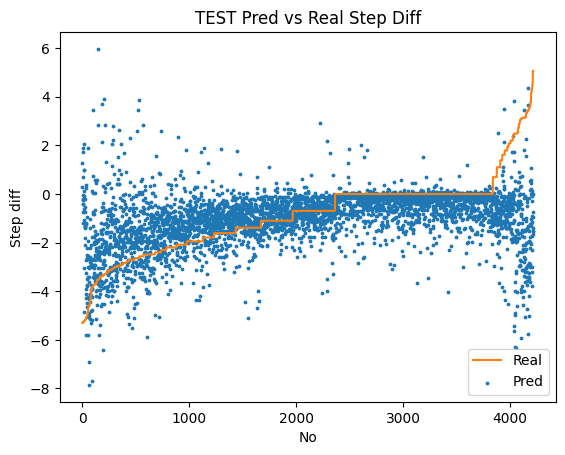

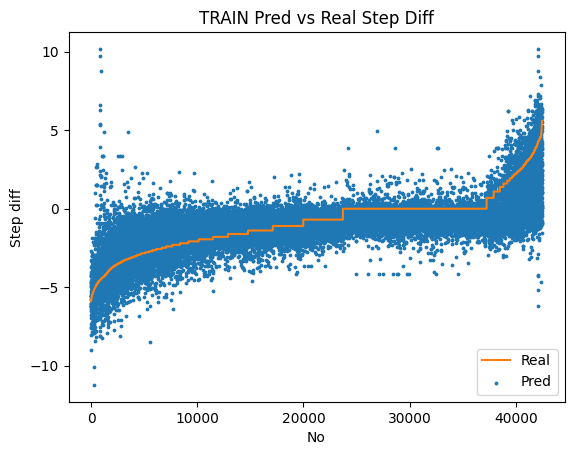

In [37]:
draw_pred_lines_scatter([x_[0] for x_ in y_test_pred], list(y_test_nums), "TEST")
draw_pred_lines_scatter([x_[0] for x_ in y_train_pred], list(y_train_nums), "TRAIN")

In [24]:
rmse_test = mean_squared_error(list(y_test_nums), [x_[0] for x_ in y_test_pred], squared=False)
rmse_train = mean_squared_error(list(y_train_nums), [x_[0] for x_ in y_train_pred], squared=False)
print("TEST {Root Mean Squared Error}:", rmse_test)
print("TRAIN {Root Mean Squared Error}:", rmse_train, "\n")

mse_test = mean_squared_error(list(y_test_nums), [x_[0] for x_ in y_test_pred], squared=True)
mse_train = mean_squared_error(list(y_train_nums), [x_[0] for x_ in y_train_pred], squared=True)
print("TEST {Mean Squared Error}:", mse_test)
print("TRAIN {Mean Squared Error}:", mse_train, "\n")

mae_test = mean_absolute_error(list(y_test_nums), [x_[0] for x_ in y_test_pred])
mae_train = mean_absolute_error(list(y_train_nums), [x_[0] for x_ in y_train_pred])
print("TEST {Mean Absolute Error}:", mae_test)
print("TRAIN {Mean Absolute Error}:", mae_train, "\n")

TEST {Root Mean Squared Error}: 1.6458201189215147
TRAIN {Root Mean Squared Error}: 1.1298882134110557 

TEST {Mean Squared Error}: 2.7087238638468287
TRAIN {Mean Squared Error}: 1.2766473748052274 

TEST {Mean Absolute Error}: 0.9954842957000302
TRAIN {Mean Absolute Error}: 0.7686873516423787 



## check correctness for step estimation

In [42]:
y_test_pred = conv_to_steps(y_test_pred)
y_train_pred = conv_to_steps(y_train_pred)

y_tesn_nums = conv_to_steps(y_test_nums)
y_train_nums = conv_to_steps(y_train_nums)

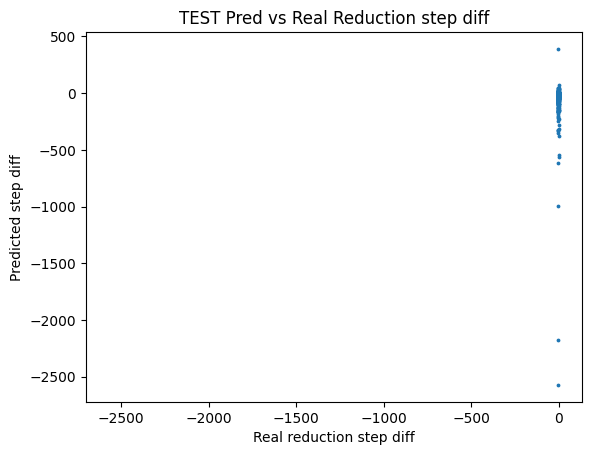

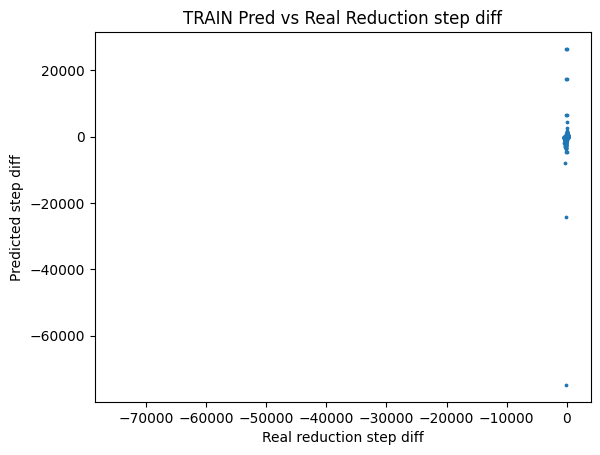

In [43]:
draw_pred_scatter(y_test_pred, y_test_nums, "TEST")
draw_pred_scatter(y_train_pred, y_train_nums, "TRAIN")

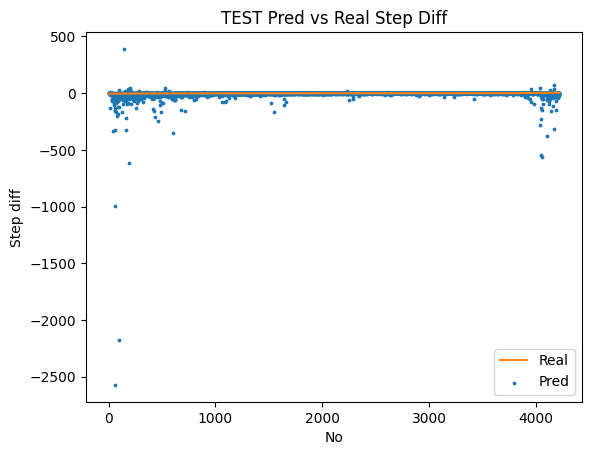

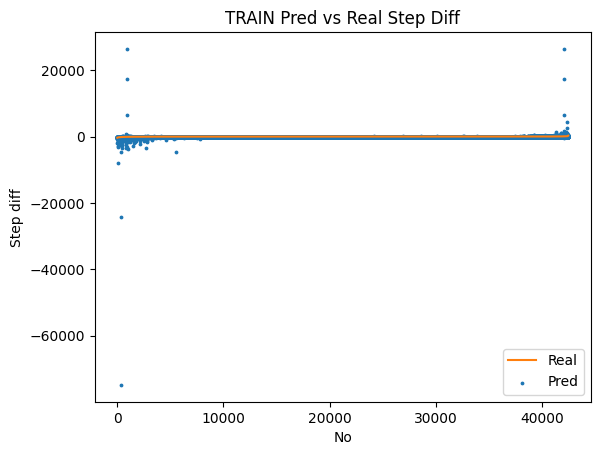

In [44]:
draw_pred_lines_scatter([x_[0] for x_ in y_test_pred], list(y_test_nums), "TEST")
draw_pred_lines_scatter([x_[0] for x_ in y_train_pred], list(y_train_nums), "TRAIN")

In [45]:
rmse_test = mean_squared_error(list(y_test_nums), [x_[0] for x_ in y_test_pred], squared=False)
rmse_train = mean_squared_error(list(y_train_nums), [x_[0] for x_ in y_train_pred], squared=False)
print("TEST {Root Mean Squared Error}:", rmse_test)
print("TRAIN {Root Mean Squared Error}:", rmse_train, "\n")

mse_test = mean_squared_error(list(y_test_nums), [x_[0] for x_ in y_test_pred], squared=True)
mse_train = mean_squared_error(list(y_train_nums), [x_[0] for x_ in y_train_pred], squared=True)
print("TEST {Mean Squared Error}:", mse_test)
print("TRAIN {Mean Squared Error}:", mse_train, "\n")

mae_test = mean_absolute_error(list(y_test_nums), [x_[0] for x_ in y_test_pred])
mae_train = mean_absolute_error(list(y_train_nums), [x_[0] for x_ in y_train_pred])
print("TEST {Mean Absolute Error}:", mae_test)
print("TRAIN {Mean Absolute Error}:", mae_train, "\n")

TEST {Root Mean Squared Error}: 60.4302726526191
TRAIN {Root Mean Squared Error}: 450.84422755470655 

TEST {Mean Squared Error}: 3651.817852869884
TRAIN {Mean Squared Error}: 203260.51751940002 

TEST {Mean Absolute Error}: 7.457901555993957
TRAIN {Mean Absolute Error}: 18.83124540770808 



# Best validation MSE-score model

In [49]:
# load the model
from transformers import TFBertModel

with open("./fine_models/model_diff_v1.json", "r") as file:
    loaded_model_json = file.read()

model = tf.keras.models.model_from_json(loaded_model_json, custom_objects={"TFBertModel": TFBertModel})
model.load_weights('./fine_models/model_diff_best_MSE_v1.h5')

In [50]:
y_test_pred = model.predict(test_dataset)
y_train_pred = model.predict(train_dataset)

y_test_nums = test_df["diff_steps"]
y_train_nums = train_df["diff_steps"]

664/664 [==============================] - 33s 49ms/step


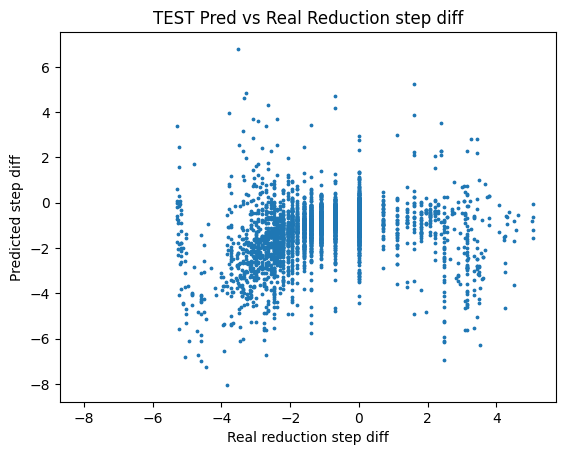

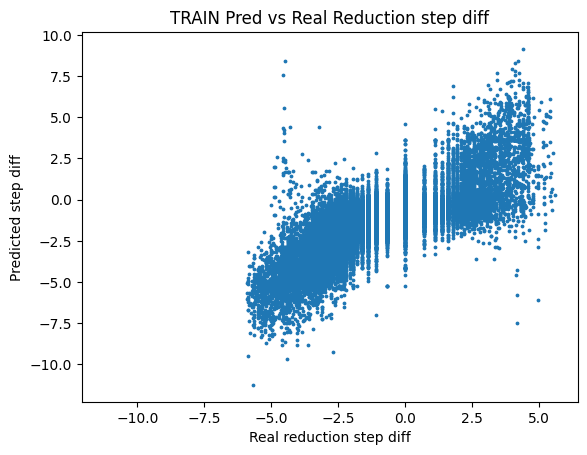

In [51]:
draw_pred_scatter(y_test_pred, y_test_nums, "TEST")
draw_pred_scatter(y_train_pred, y_train_nums, "TRAIN")

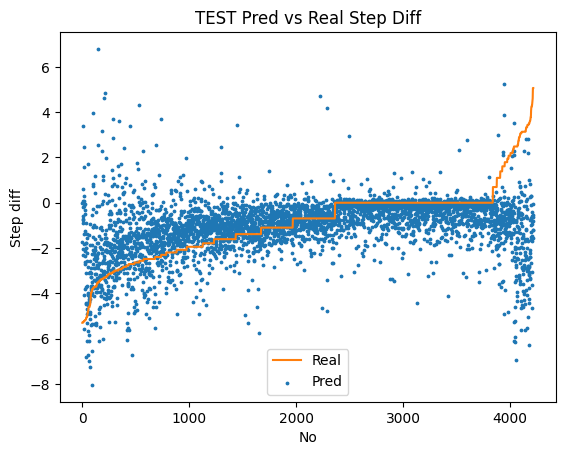

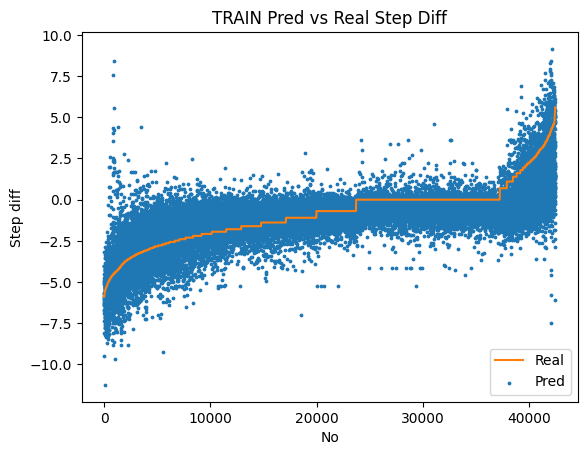

In [52]:
draw_pred_lines_scatter([x_[0] for x_ in y_test_pred], list(y_test_nums), "TEST")
draw_pred_lines_scatter([x_[0] for x_ in y_train_pred], list(y_train_nums), "TRAIN")

In [53]:
rmse_test = mean_squared_error(list(y_test_nums), [x_[0] for x_ in y_test_pred], squared=False)
rmse_train = mean_squared_error(list(y_train_nums), [x_[0] for x_ in y_train_pred], squared=False)
print("TEST {Root Mean Squared Error}:", rmse_test)
print("TRAIN {Root Mean Squared Error}:", rmse_train, "\n")

mse_test = mean_squared_error(list(y_test_nums), [x_[0] for x_ in y_test_pred], squared=True)
mse_train = mean_squared_error(list(y_train_nums), [x_[0] for x_ in y_train_pred], squared=True)
print("TEST {Mean Squared Error}:", mse_test)
print("TRAIN {Mean Squared Error}:", mse_train, "\n")

mae_test = mean_absolute_error(list(y_test_nums), [x_[0] for x_ in y_test_pred])
mae_train = mean_absolute_error(list(y_train_nums), [x_[0] for x_ in y_train_pred])
print("TEST {Mean Absolute Error}:", mae_test)
print("TRAIN {Mean Absolute Error}:", mae_train, "\n")

TEST {Root Mean Squared Error}: 1.7058585320240365
TRAIN {Root Mean Squared Error}: 1.1485286761080267 

TEST {Mean Squared Error}: 2.9099533312792008
TRAIN {Mean Squared Error}: 1.3191181198424566 

TEST {Mean Absolute Error}: 1.0256248684551563
TRAIN {Mean Absolute Error}: 0.7852686466936138 



## Check correctness for step estimation

In [54]:
y_test_pred = conv_to_steps(y_test_pred)
y_train_pred = conv_to_steps(y_train_pred)

y_tesn_nums = conv_to_steps(y_test_nums)
y_train_nums = conv_to_steps(y_train_nums)

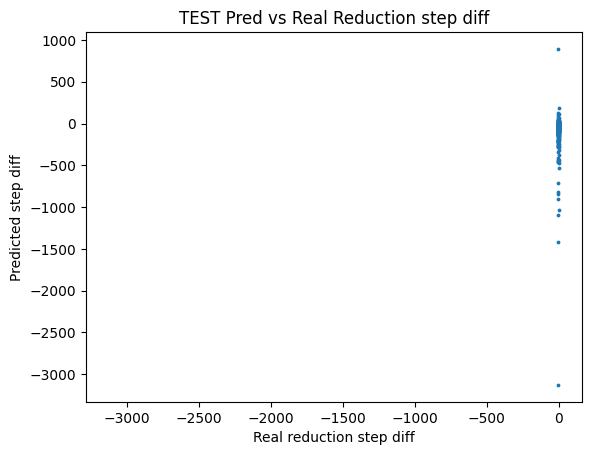

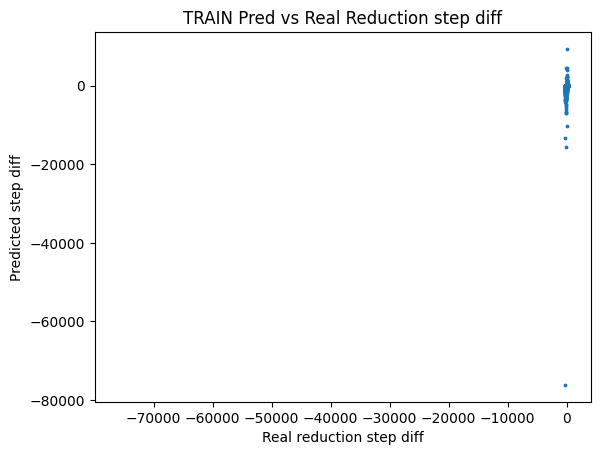

In [55]:
draw_pred_scatter(y_test_pred, y_test_nums, "TEST")
draw_pred_scatter(y_train_pred, y_train_nums, "TRAIN")

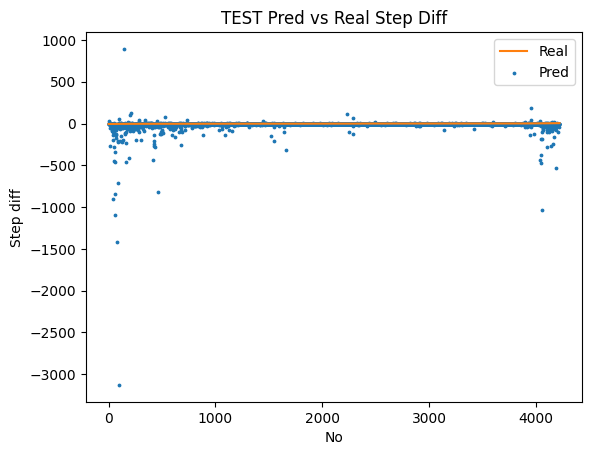

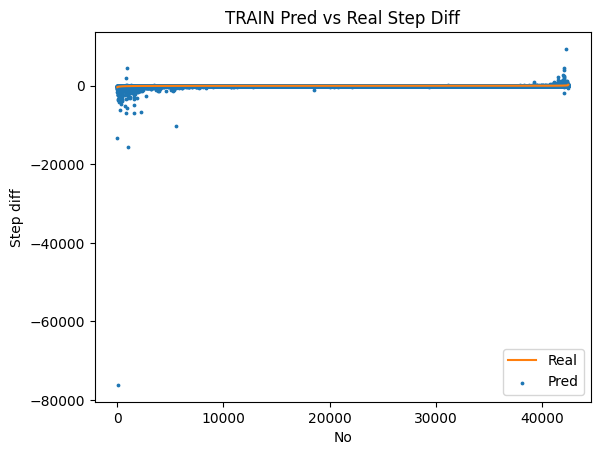

In [56]:
draw_pred_lines_scatter([x_[0] for x_ in y_test_pred], list(y_test_nums), "TEST")
draw_pred_lines_scatter([x_[0] for x_ in y_train_pred], list(y_train_nums), "TRAIN")

In [57]:
rmse_test = mean_squared_error(list(y_test_nums), [x_[0] for x_ in y_test_pred], squared=False)
rmse_train = mean_squared_error(list(y_train_nums), [x_[0] for x_ in y_train_pred], squared=False)
print("TEST {Root Mean Squared Error}:", rmse_test)
print("TRAIN {Root Mean Squared Error}:", rmse_train, "\n")

mse_test = mean_squared_error(list(y_test_nums), [x_[0] for x_ in y_test_pred], squared=True)
mse_train = mean_squared_error(list(y_train_nums), [x_[0] for x_ in y_train_pred], squared=True)
print("TEST {Mean Squared Error}:", mse_test)
print("TRAIN {Mean Squared Error}:", mse_train, "\n")

mae_test = mean_absolute_error(list(y_test_nums), [x_[0] for x_ in y_test_pred])
mae_train = mean_absolute_error(list(y_train_nums), [x_[0] for x_ in y_train_pred])
print("TEST {Mean Absolute Error}:", mae_test)
print("TRAIN {Mean Absolute Error}:", mae_train, "\n")

TEST {Root Mean Squared Error}: 71.78260878177942
TRAIN {Root Mean Squared Error}: 413.3639460451891 

TEST {Mean Squared Error}: 5152.742923517995
TRAIN {Mean Squared Error}: 170869.75189005 

TEST {Mean Absolute Error}: 10.060114978571777
TRAIN {Mean Absolute Error}: 22.717284413516815 

